In [1]:
using Distributions, DistributionsAD, Plots, StatsPlots, LinearAlgebra, KernelFunctions, BlockDiagonals, MLDatasets, Zygote, LinearAlgebra

In [2]:
import Base.+, Base.-, Base.*
using Flux


struct Gaussian
    μ
    Σ
end
Flux.@functor Gaussian


+(x::Gaussian, y::Gaussian) = Gaussian(x.μ .+ y.μ, x.Σ .+ y.Σ)
+(x::Gaussian, y::Vector) = Gaussian(x.μ .+ y, x.Σ)
+(x::Vector, y::Gaussian) = Gaussian(x .+ y.μ, y.Σ)

-(x::Gaussian, y::Gaussian) = Gaussian(x.μ .- y.μ, x.Σ .+ y.Σ)
-(x::Gaussian, y::Vector) = Gaussian(x.μ .- y, x.Σ)
-(x::Vector, y::Gaussian) = Gaussian(x .- y.μ, y.Σ)

*(x::Matrix, y::Gaussian) = Gaussian(x*y.μ, (x)*y.Σ*transpose(x))
        
*(x::Gaussian, y::Real) = Gaussian(y.*x.μ, y^2 .*x.Σ)
*(x::Real, y::Gaussian) = Gaussian(x.*y.μ, x^2 .*y.Σ)

Gaussian(m::Gaussian, S) = Gaussian(m.μ, S.+m.Σ)
Distributions.MvNormal(m::Gaussian) = Distributions.MvNormal(m.μ, Matrix(Hermitian(m.Σ.+Diagonal(ones(length(m.μ)).*1e-6))))

In [3]:
mutable struct SEKernel <: KernelFunctions.Kernel
     
    se_variance
    se_lengthscale

end

Flux.@functor SEKernel


SEKernel() = SEKernel(zeros(1,1), zeros(1,1))


function KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix,y::Matrix)

    diffed = sum((Flux.unsqueeze(x,3) .- Flux.unsqueeze(y,2)).^2,dims=1)[1,:,:]
    
    return exp(m.se_variance[1,1]) .* exp.(- 0.5 *exp(m.se_lengthscale[1,1]) .* diffed)

end

KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix) = KernelFunctions.kernelmatrix(m,x,x)


function crossderivativekernel(m::SEKernel,x::Matrix,y::Matrix,i=1)

    diffed = (Flux.unsqueeze(x[i:i,:],3) .- Flux.unsqueeze(y[i:i,:],2))[1,:,:]
    kern = kernelmatrix(m,x,y)
    
    result =  exp(m.se_lengthscale[1,1]) .* diffed .* kern
    
    return result
    
end


crossderivativekernel(m::SEKernel,x::Matrix) = crossderivativekernel(m,x,x)
crossderivativekernel(m::SEKernel,x::Matrix,i::Int) = crossderivativekernel(m,x,x,i)


function doaug(k,n,m)
    
    result = zeros(k,k,n,m,k*n,k*m)
    
    for i in 1:k
        for j in 1:k
            for s in 1:n
                for t in 1:m
                    result[i,j,s,t,((i-1)*n+s),((j-1)*m+t)] = 1.
                end
            end
        end
    end
    
    return result
end
Zygote.@nograd doaug


function derivativekernel(m::SEKernel, x::Matrix, y::Matrix,i=1)
    
    diffed = (Flux.unsqueeze(x[i:i,:],3) .- Flux.unsqueeze(y[i:i,:],2))[1,:,:]

    kern = kernelmatrix(m,x,y)
    
    result =  (exp(m.se_lengthscale[1,1]) .- exp(m.se_lengthscale[1,1]).^2 .* diffed.^2) .* kern
        
    return result
end


derivativekernel(m::SEKernel,x::Matrix) = derivativekernel(m,x,x)
derivativekernel(m::SEKernel,x::Matrix,i::Int) = derivativekernel(m,x,x,i)

derivativekernel (generic function with 4 methods)

In [76]:
struct GPModel
    kern
    s
end
Flux.@functor GPModel

GPModel(kern) = GPModel(kern, ones(1,1))


function loglikeloss(m::GPModel, X, y)
    
    s = exp(m.s[1])
    K = kernelmatrix(m.kern,X)
    
    return logpdf(MvNormal(zeros(size(y,2)), K.+Diagonal(ones(size(y,2)).*s)),y[:])
    
end
    

loglikeloss (generic function with 1 method)

In [79]:
using CSV, DataFrames

In [80]:
df = CSV.File("./data/boston_housing.csv") |> DataFrame
X = Matrix(transpose(Matrix(df[:,1:end-1])))
X = (X.-mean(X,dims=2))./std(X,dims=2)

y = Matrix(transpose(Matrix(df[:,end:end])))
y = (y.-mean(y))./std(y)

1×506 Matrix{Float64}:
 0.159528  -0.101424  1.32294  1.18159  …  0.148655  -0.057932  -1.1561

In [134]:
using Random
Random.seed!(123)
test = GPModel(SEKernel())

params = Flux.params(test)
opt = ADAM(0.005)


for i in 1:2000
    
    grads = Zygote.gradient(()-> - loglikeloss(test,X,y), params)
    Flux.Optimise.update!(opt,params,grads)
    
    if i % 50 == 0
        println(loglikeloss(test,X,y))
    end
    
end

-758.7730938006492
-700.8107870413774
-644.0122347017747
-587.9198408526172
-532.645799991047
-479.40558827066616
-429.93676659892776
-385.5556354993821
-346.90845699546276
-314.15088052771705
-287.12999501138717
-265.48321006701394
-248.68474572328566
-236.08156310544675
-226.94425146631133
-220.5325159716746
-216.15952049687323
-213.23936886444855
-211.3099427450326
-210.03222610550037
-209.17330709547073
-208.58200931382837
-208.16442942473768
-207.86359440372823
-207.64467602499226
-207.48540487145058
-207.3704901035188
-207.2886900869093
-207.231396080353
-207.19195022363314
-207.16525908832327
-207.14750553378587
-207.13589515849787
-207.12842901267462
-207.12370807386418
-207.12077321051842
-207.11897977362074
-207.11790279026445
-207.11726742450557
-207.1168993101481


In [144]:
function getIGdist(m::GPModel, target,x, y,Kmmi,i)
    
    alpha = Matrix(transpose(collect(0.1:0.1:1)[:,:]))
    targetAlpha = target.*alpha
    G = ones(10,1)./10
    
    Knn = derivativekernel(m.kern,targetAlpha,targetAlpha,i)
    
    Kmn = derivativekernel(m.kern,x,targetAlpha,i)
 
    
    mp = y*Kmmi*Kmn
 
    Sp = Knn .- transpose(Kmn)*Kmmi*Kmn
    
    
    
    return Gaussian((mp*G)[:],transpose(G)*Sp*G)
    
    
end

getIGdist (generic function with 3 methods)

In [145]:
Kmm = kernelmatrix(test.kern,X).+Diagonal(ones(size(X,2)).*exp(test.s[1]))
Kmmi = inv(Kmm)

506×506 Matrix{Float64}:
 10.8214      -0.248483    -0.312105   …   0.0969439    0.092451
 -0.248483    14.0347      -1.22995        0.00677839  -0.0784552
 -0.312105    -1.22995     13.0873        -0.35839      0.0998786
 -0.0568161   -0.0146634   -1.16617       -0.014123    -0.0100251
  0.122264    -0.384557    -1.12095        0.0824666    0.0576873
 -0.296333    -0.785346    -0.443134   …   0.0715604    0.0411516
 -0.801123    -0.142076     0.0394877     -0.0104749    0.102549
 -0.0201983   -0.318686     0.0696841      0.0378093    0.0216131
  0.200232     0.401722    -0.101758      -0.0449641   -0.137561
 -0.0298846   -0.0925501    0.07132       -0.0270946    0.0365973
  0.130269    -0.145328     0.0767469  …   0.0683077   -0.155944
 -0.634343    -0.482777     0.0510596      0.0371427    0.152262
  0.0753378    0.432791     0.0680937     -0.124108    -0.102008
  ⋮                                    ⋱                ⋮
  0.0208233   -0.0248718    0.102092       0.165109     0.0926027

In [146]:
meanExps = hcat([[getIGdist(test,X[:,j:j],X,y,Kmmi,i).μ[1] for i in 1:size(X,1)] for j in 1:size(X,2)]...)
varExps = hcat([[getIGdist(test,X[:,j:j],X,y,Kmmi,i).Σ[1] for i in 1:size(X,1)] for j in 1:size(X,2)]...)

13×506 Matrix{Float64}:
 0.163741  0.167068  0.163836  0.160778  …  0.162125  0.163306  0.164589
 0.146294  0.15228   0.147698  0.142511     0.154104  0.155047  0.156111
 0.143545  0.146697  0.144613  0.141644     0.142939  0.143656  0.14431
 0.155292  0.158632  0.155183  0.152096     0.156117  0.157255  0.158606
 0.15197   0.156357  0.153712  0.152026     0.152011  0.152991  0.154119
 0.13593   0.140253  0.131873  0.130627  …  0.136201  0.13831   0.142051
 0.137755  0.140196  0.136232  0.13154      0.140938  0.141526  0.14132
 0.144804  0.144342  0.141648  0.135127     0.148444  0.149258  0.149696
 0.159785  0.163155  0.159816  0.157204     0.158241  0.159329  0.160574
 0.155162  0.156575  0.153618  0.150639     0.153626  0.154537  0.155406
 0.133593  0.138568  0.136455  0.134923  …  0.139602  0.14031   0.140748
 0.153371  0.154397  0.152397  0.150371     0.148513  0.149421  0.150678
 0.14406   0.145237  0.14449   0.141598     0.143536  0.144168  0.143902

In [147]:
mean(meanExps,dims=2)[:]

13-element Vector{Float64}:
 -0.018515337732039054
 -0.0004750664042506836
 -0.06789437365084536
 -0.0427104235939467
  0.06354146963500422
 -0.19417511114120825
 -0.04571115261615835
 -0.23890122734463237
  0.15108160365917525
 -0.1248656428641304
 -0.1038574533276315
  0.09084273551869802
 -0.11568060865488025

In [148]:
mean(varExps,dims=2)[:]

13-element Vector{Float64}:
 0.1529410514969407
 0.1453038195463224
 0.14198419016383
 0.14938061474482145
 0.14609296597747
 0.13315877040428664
 0.13614232064449042
 0.14154313149625683
 0.15369155076060556
 0.1486481222787057
 0.1363203247596587
 0.14316287003805328
 0.13723897414982641

In [149]:
names(df)

14-element Vector{String}:
 "crim"
 "zn"
 "indus"
 "chas"
 "nox"
 "rm"
 "age"
 "dis"
 "rad"
 "tax"
 "ptratio"
 "black"
 "lstat"
 "medv"

In [150]:
meanExps = [getIGdist(test,X[:,1:1],i).μ[1] for i in 1:size(X,1)]
varExps = [getIGdist(test,X[:,1:1],i).Σ[1] for i in 1:size(X,1)]

LoadError: MethodError: no method matching getIGdist(::GPModel, ::Matrix{Float64}, ::Int64)
[0mClosest candidates are:
[0m  getIGdist(::GPModel, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m) at In[143]:1
[0m  getIGdist(::GPModel, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m) at In[144]:1
[0m  getIGdist([91m::SVGPG[39m, ::Any, ::Any) at In[45]:1

In [151]:
meanExps = [getIGdist(test,5 .* ones(13,1),i).μ[1] for i in 1:size(X,1)]
varExps = [getIGdist(test,5 .*ones(13,1),i).Σ[1] for i in 1:size(X,1)]

LoadError: MethodError: no method matching getIGdist(::GPModel, ::Matrix{Float64}, ::Int64)
[0mClosest candidates are:
[0m  getIGdist(::GPModel, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m) at In[143]:1
[0m  getIGdist(::GPModel, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m) at In[144]:1
[0m  getIGdist([91m::SVGPG[39m, ::Any, ::Any) at In[45]:1

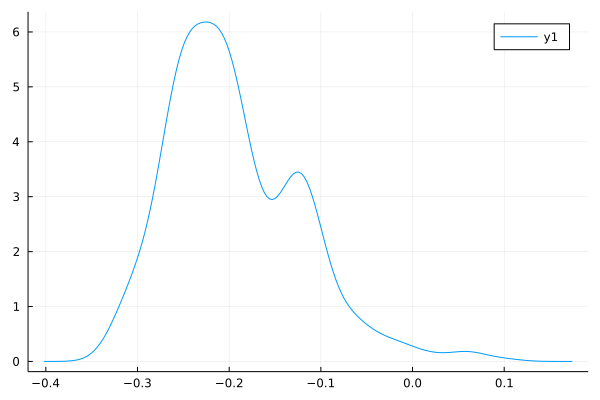

In [152]:
density(meanExps[6,:])

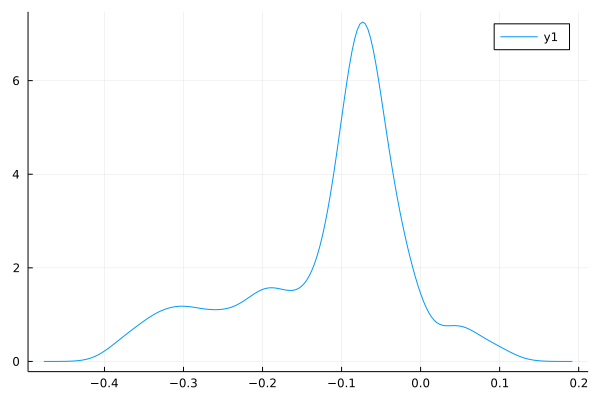

In [153]:
density(meanExps[13,:])

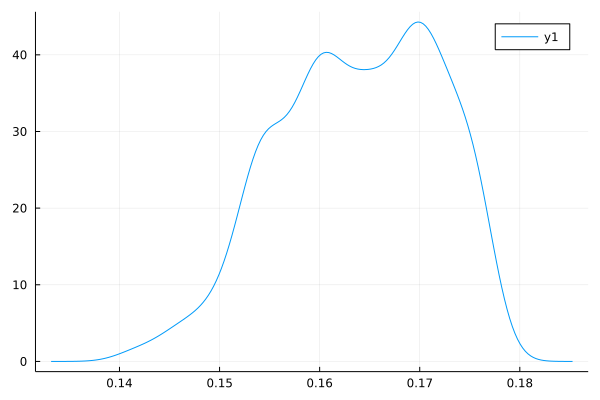

In [142]:
density(varExps[12,:])